In [1]:
'''Generate a data set that has the variables and the task in this note .'''
# We will use a decision tree to understand what factors in each patients history led to them responding well to 
# one specific medication over the others. 
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
import graphviz 

In [2]:
# Task One: generate a sheet with variables 
# Age Sex BP Cholesterol Na K Drug
# fill the values of "Age Sex BP Cholesterol Na K " randomly,
# Drug value will be filled according to the rules give (with some pertubation)

In [3]:
def initialization(num=100):
    '''
    Define a function to randomly generate patients' data
    '''
    # value of Age ranges from 15 to 74
    Age = pd.Series(np.random.randint(15,75,size=num),name='Age')
    # Sex is either F or M
    Sex = pd.Series(np.random.choice(['F','M'],size=num),name='Sex')
    # Blood Pressure can be "HIGH","NORMAL", or "LOW"
    BP = pd.Series(np.random.choice(['HIGH','NORMAL','LOW'],size=num),name='BP')
    # Cholesterol has value "HIGH" or "NORMAL"
    Cholesterol = pd.Series(np.random.choice(['HIGH','NORMAL'],size=num),name='Cholesterol')
    # Na: level of sodium ranges from 0.5 to 0.9
    Na = pd.Series(np.random.randint(500,901,size=num)/1000,name='Na')
    # K: level of potassium ranges from 0.02 to 0.08
    K = pd.Series(np.random.randint(20,90,size=num)/1000,name='K')
    # Drug: fill it with NaN
    Drug = pd.Series(np.array(num*['']).T,name='Drug')
    # Na_to_K
    NatoK=pd.Series(Na/K,name='Na_to_K')
    # Create a pandas dataframe by Concatenate all series
    df = pd.concat([Age,Sex,BP,Cholesterol,Na,K,Drug,NatoK],axis=1)
    return df

In [4]:
def drugsAssignment(df,randomDrug=0.03):
    '''
    Based on the given rules in https://www.datasciencecentral.com/profiles/blogs/using-decision-trees-in-evidence-based-medicine,
    we will fill the values of column Drug
    '''
    # Rule for drug A
    RA1 = (df["Na_to_K"]<=14.64)&(df["BP"]=="HIGH")&(df["Age"]<=50)
    # Rule for drug B
    RB1 = (df["Na_to_K"]<=14.64)&(df["BP"]=="HIGH")&(df["Age"]>50)
    # Rule for drug C
    RC1 = (df["Na_to_K"]<=14.64)&(df["BP"]=="LOW")&(df["Cholesterol"]=="HIGH")
    # Rule for drug X
    RX1 = (df["Na_to_K"]<=14.64)&(df["BP"]=="LOW")&(df["Cholesterol"]=="NORMAL")
    RX2 = (df["Na_to_K"]<=14.64)&(df["BP"]=="NORMAL")
    # Rule for drug Y
    RY1 = (df["Na_to_K"]>14.64)
    ##
    ## Now for 95% of the patients we fill the values of Drugs according to the rules above. For the rest 5%, drug's value will be random
    dpool=['drugA','drugB','drugC','drugX','drugY']
    for i in range(len(df)):
        # Generate a random number, if it is <=randomDrug, assign the drug value randomly.
        if np.random.rand()<randomDrug:
            df.at[i,"Drug"]=np.random.choice(dpool)
            continue
        if RY1.iloc[i]:
            df.at[i,"Drug"]="drugY"
            continue
        if RX2.iloc[i]:
            df.at[i,"Drug"]="drugX"
            continue
        if RA1.iloc[i]:
            df.at[i,"Drug"]="drugA"
            continue
        if RB1.iloc[i]:
            df.at[i,"Drug"]="drugB"
            continue
        if RC1.iloc[i]:
            df.at[i,"Drug"]="drugC"
            continue
        if RX1.iloc[i]:
            df.at[i,"Drug"]="drugX"
            continue
        #the next line will not be used. If not conditions are satisfieed above, assign a random value.
        df.at[i,"Drug"]=np.random.choice(dpool)
    # Start the index from 1 to be compatible with the case in the given link
    df.index += 1
    return df
    

   Age Sex      BP Cholesterol     Na      K   Drug    Na_to_K
1   71   M  NORMAL      NORMAL  0.680  0.050  drugY  13.600000
2   63   M    HIGH        HIGH  0.882  0.034  drugY  25.941176
3   56   F    HIGH      NORMAL  0.645  0.065  drugB   9.923077
4   50   F     LOW      NORMAL  0.661  0.028  drugY  23.607143
5   16   M    HIGH        HIGH  0.658  0.065  drugA  10.123077


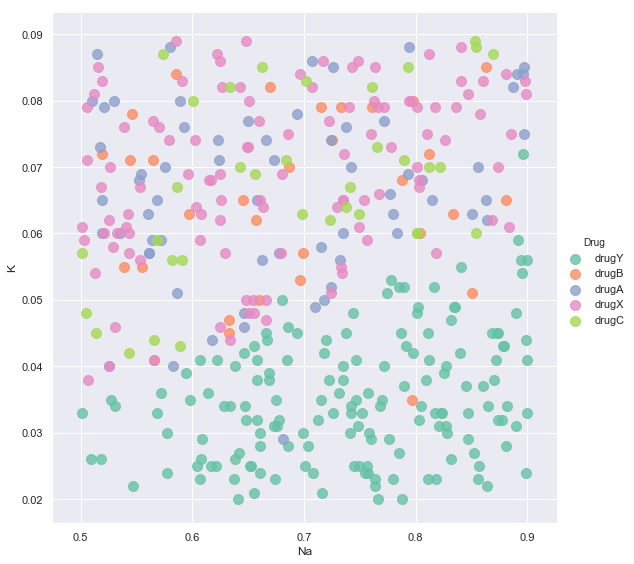

In [5]:
# Example:
# Generate a training dataset with 400 patients, and 3% of the drugs are randomly given
exa1=initialization(400)
exa1=drugsAssignment(exa1,0.03)
print(exa1.head())
# Draw the Na and K levels of the generated example to see if it matches with our expectation
sns.set()
g = sns.lmplot(x='Na', y='K', hue='Drug',data=exa1,scatter_kws={'s': 100}, 
               palette=sns.color_palette('Set2'), fit_reg=False,legend=True,height=8)

In [6]:
# codes adapted from http://scikit-learn.org/stable/modules/tree.html
def dtclassifier(df,max_depth=3):
    '''
    Given a dataframe with training data, this function returns the classifier
    '''
    # Use one hot encoding to convert categorical variables to numerical variables.
    ohe=pd.get_dummies(df)
    clf=tree.DecisionTreeClassifier(max_depth=max_depth)
    clf=clf.fit(ohe[['Age', 'Na_to_K', 'Sex_F', 'Sex_M', 'BP_HIGH', 'BP_LOW', 'BP_NORMAL',
       'Cholesterol_HIGH', 'Cholesterol_NORMAL']],ohe[['Drug_drugA', 'Drug_drugB', 'Drug_drugC', 'Drug_drugX', 'Drug_drugY']])
    return clf

In [10]:
clf=dtclassifier(exa1)
oheillus=pd.get_dummies(exa1)
# illustrate one hot encoding
oheillus[oheillus.columns[[0,3,4,5,6,7,8,9,10,11,12,13,14,15]]].head()

,Age,Na_to_K,Sex_F,Sex_M,BP_HIGH,BP_LOW,BP_NORMAL,Cholesterol_HIGH,Cholesterol_NORMAL,Drug_drugA,Drug_drugB,Drug_drugC,Drug_drugX,Drug_drugY
1,71,13.600000,0,1,0,0,1,0,1,0,0,0,0,1
2,63,25.941176,0,1,1,0,0,1,0,0,0,0,0,1
3,56,9.923077,1,0,1,0,0,0,1,0,1,0,0,0
4,50,23.607143,1,0,0,1,0,0,1,0,0,0,0,1
5,16,10.123077,0,1,1,0,0,1,0,1,0,0,0,0


In [11]:
names=pd.get_dummies(initialization(50)).columns
features = list(names[[0,3,4,5,6,7,8,9,10]])
targets = list(names[11:16])

# codes adapted from http://scikit-learn.org/stable/modules/tree.html
def graphvizExporter(classifier,filename="drugs"):
    '''
    Define a function to export a graph illustrating the decision strategies in the classifier given
    '''
    global features
    global targets
    dot_data = tree.export_graphviz(clf, out_file=None) 
    graph = graphviz.Source(dot_data) 
    graph.render(filename) 
    dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=features,  
                         class_names=targets,  
                         filled=True, rounded=True,  
                         special_characters=True)  
    graph = graphviz.Source(dot_data)  
    return graph 



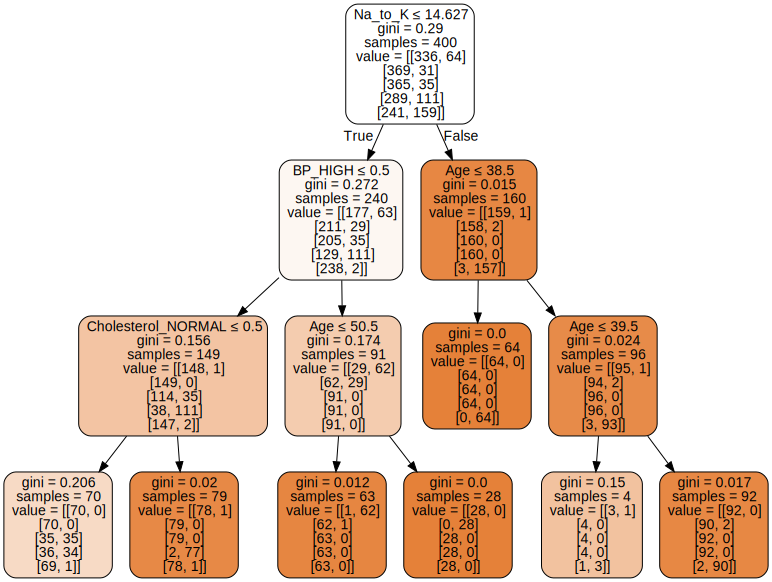

In [12]:
#Explaination of data in the nodes:
#https://stackoverflow.com/questions/47503575/what-do-the-values-that-graphviz-renders-inside-each-node-of-a-decision-tree-m
graphvizExporter(clf)

In [13]:
# Finally, generate a test set, and then use the classifer we trained to predict drugs to be given.
test_features_only=initialization(100)
test_targets=drugsAssignment(test_features_only,randomDrug=0)
test_features_only=pd.get_dummies(test_features_only)
test_features_only=test_features_only[test_features_only.columns[[0,3,4,5,6,7,8,9,10]]]
predicted=clf.predict(test_features_only)
drugs_assigned=pd.get_dummies(test_targets)[['Drug_drugA', 'Drug_drugB', 'Drug_drugC', 'Drug_drugX', 'Drug_drugY']].values

In [14]:
def accuracy(pred,fact):
    '''
    Function to calculate the accuracy rate of predicted drugs,
    given two arrays of one hot encoded categorical features
    '''
    temp=map(lambda x:(x**2).sum(),(pred-fact))
    temp=np.array(list(temp)).sum()/2
    return 1-temp/len(pred)

In [15]:
accuracy(predicted,drugs_assigned)

0.915